<h1> Data Science Coursera Capstone <h1>

# Introduction
Cars transformed modern society to what it is now and literally sped up economic activities – bringing in financial growth and opportunities to the masses. But all of this came at a cost. Road traffic injuries are estimated to be the eighth leading cause of death globally for all age groups and the leading cause of death for children and young people 5–29 years of age. More people now die in road traffic crashes than from HIV/AIDS [1]. The ability to predict these unfortunate events will help transport authorities to implement policies and laws based on factors that are directly impact the safety of car drivers.

# Data Description

In [3]:
import itertools
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import NullFormatter
import pandas as pd
import numpy as np
import matplotlib.ticker as ticker
from sklearn import preprocessing

In [4]:
df = pd.read_csv('/content/drive/My Drive/School Stuff/Coursera/Data-Collisions.csv')
df.head()

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (33) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,SEVERITYCODE,X,Y,OBJECTID,INCKEY,COLDETKEY,REPORTNO,STATUS,ADDRTYPE,INTKEY,LOCATION,EXCEPTRSNCODE,EXCEPTRSNDESC,SEVERITYCODE.1,SEVERITYDESC,COLLISIONTYPE,PERSONCOUNT,PEDCOUNT,PEDCYLCOUNT,VEHCOUNT,INCDATE,INCDTTM,JUNCTIONTYPE,SDOT_COLCODE,SDOT_COLDESC,INATTENTIONIND,UNDERINFL,WEATHER,ROADCOND,LIGHTCOND,PEDROWNOTGRNT,SDOTCOLNUM,SPEEDING,ST_COLCODE,ST_COLDESC,SEGLANEKEY,CROSSWALKKEY,HITPARKEDCAR
0,2,-122.323148,47.703140,1,1307,1307,3502005,Matched,Intersection,37475.0,5TH AVE NE AND NE 103RD ST,,NaN,2,Injury Collision,Angles,2,0,0,2,2013/03/27 00:00:00+00,3/27/2013 2:54:00 PM,At Intersection (intersection related),11,"MOTOR VEHICLE STRUCK MOTOR VEHICLE, FRONT END ...",NaN,N,Overcast,Wet,Daylight,NaN,NaN,NaN,10,Entering at angle,0,0,N
1,1,-122.347294,47.647172,2,52200,52200,2607959,Matched,Block,NaN,AURORA BR BETWEEN RAYE ST AND BRIDGE WAY N,NaN,NaN,1,Property Damage Only Collision,Sideswipe,2,0,0,2,2006/12/20 00:00:00+00,12/20/2006 6:55:00 PM,Mid-Block (not related to intersection),16,"MOTOR VEHICLE STRUCK MOTOR VEHICLE, LEFT SIDE ...",NaN,0,Raining,Wet,Dark - Street Lights On,NaN,6354039.0,NaN,11,From same direction - both going straight - bo...,0,0,N
2,1,-122.334540,47.607871,3,26700,26700,1482393,Matched,Block,NaN,4TH AVE BETWEEN SENECA ST AND UNIVERSITY ST,NaN,NaN,1,Property Damage Only Collision,Parked Car,4,0,0,3,2004/11/18 00:00:00+00,11/18/2004 10:20:00 AM,Mid-Block (not related to intersection),14,"MOTOR VEHICLE STRUCK MOTOR VEHICLE, REAR END",NaN,0,Overcast,Dry,Daylight,NaN,4323031.0,NaN,32,One parked--one moving,0,0,N
3,1,-122.334803,47.604803,4,1144,1144,3503937,Matched,Block,NaN,2ND AVE BETWEEN MARION ST AND MADISON ST,,NaN,1,Property Damage Only Collision,Other,3,0,0,3,2013/03/29 00:00:00+00,3/29/2013 9:26:00 AM,Mid-Block (not related to intersection),11,"MOTOR VEHICLE STRUCK MOTOR VEHICLE, FRONT END ...",NaN,N,Clear,Dry,Daylight,NaN,NaN,NaN,23,From same direction - all others,0,0,N
4,2,-122.306426,47.545739,5,17700,17700,1807429,Matched,Intersection,34387.0,SWIFT AVE S AND SWIFT AV OFF RP,NaN,NaN,2,Injury Collision,Angles,2,0,0,2,2004/01/28 00:00:00+00,1/28/2004 8:04:00 AM,At Intersection (intersection related),11,"MOTOR VEHICLE STRUCK MOTOR VEHICLE, FRONT END ...",NaN,0,Raining,Wet,Daylight,NaN,4028032.0,NaN,10,Entering at angle,0,0,N



The [original dataset ](https://s3.us.cloud-object-storage.appdomain.cloud/cf-courses-data/CognitiveClass/DP0701EN/version-2/Data-Collisions.csv)had irrelevant attributes, so we decided to cut down to the following features:
*	SEVERITYCODE - A code that corresponds to the severity of the collision
*	ROADCOND - The condition of the road during the collision
*	WEATHER - A description of the weather conditions during the time of the collision
*	LIGHTCOND - The light conditions during the collision
*	ADDRTYPE - Collision address type (Alley, Block, Intersection)

The dataset to be used was then extracted as follows:


In [5]:
df = df[['SEVERITYCODE', 'ROADCOND', 'WEATHER', 'LIGHTCOND', 'ADDRTYPE']]
df

,SEVERITYCODE,ROADCOND,WEATHER,LIGHTCOND,ADDRTYPE
0,2,Wet,Overcast,Daylight,Intersection
1,1,Wet,Raining,Dark - Street Lights On,Block
2,1,Dry,Overcast,Daylight,Block
3,1,Dry,Clear,Daylight,Block
4,2,Wet,Raining,Daylight,Intersection
...,...,...,...,...,...
194668,2,Dry,Clear,Daylight,Block
194669,1,Wet,Raining,Daylight,Block
194670,2,Dry,Clear,Daylight,Intersection
194671,2,Dry,Clear,Dusk,Intersection


We then converted the columns into categorical data types

In [6]:
df["ROADCOND"] = df["ROADCOND"].astype('category')
df["WEATHER"] = df["WEATHER"].astype('category')
df["LIGHTCOND"] = df["LIGHTCOND"].astype('category')
df["ADDRTYPE"] = df["ADDRTYPE"].astype('category')

df["ROADCOND_CAT"] = df["ROADCOND"].cat.codes
df["WEATHER_CAT"] = df["WEATHER"].cat.codes
df["LIGHTCOND_CAT"] = df["LIGHTCOND"].cat.codes
df["ADDRTYPE_CAT"] = df["ADDRTYPE"].cat.codes

df

,SEVERITYCODE,ROADCOND,WEATHER,LIGHTCOND,ADDRTYPE,ROADCOND_CAT,WEATHER_CAT,LIGHTCOND_CAT,ADDRTYPE_CAT
0,2,Wet,Overcast,Daylight,Intersection,8,4,5,2
1,1,Wet,Raining,Dark - Street Lights On,Block,8,6,2,1
2,1,Dry,Overcast,Daylight,Block,0,4,5,1
3,1,Dry,Clear,Daylight,Block,0,1,5,1
4,2,Wet,Raining,Daylight,Intersection,8,6,5,2
...,...,...,...,...,...,...,...,...,...
194668,2,Dry,Clear,Daylight,Block,0,1,5,1
194669,1,Wet,Raining,Daylight,Block,8,6,5,1
194670,2,Dry,Clear,Daylight,Intersection,0,1,5,2
194671,2,Dry,Clear,Dusk,Intersection,0,1,6,2


In [7]:
df.dtypes

SEVERITYCODE        int64
ROADCOND         category
WEATHER          category
LIGHTCOND        category
ADDRTYPE         category
ROADCOND_CAT         int8
WEATHER_CAT          int8
LIGHTCOND_CAT        int8
ADDRTYPE_CAT         int8
dtype: object

In [8]:
df["SEVERITYCODE"].value_counts()

1    136485
2     58188
Name: SEVERITYCODE, dtype: int64

In [9]:
df["ROADCOND"].value_counts()

Dry               124510
Wet                47474
Unknown            15078
Ice                 1209
Snow/Slush          1004
Other                132
Standing Water       115
Sand/Mud/Dirt         75
Oil                   64
Name: ROADCOND, dtype: int64

In [10]:
df["WEATHER"].value_counts()

Clear                       111135
Raining                      33145
Overcast                     27714
Unknown                      15091
Snowing                        907
Other                          832
Fog/Smog/Smoke                 569
Sleet/Hail/Freezing Rain       113
Blowing Sand/Dirt               56
Severe Crosswind                25
Partly Cloudy                    5
Name: WEATHER, dtype: int64

In [11]:
df["LIGHTCOND"].value_counts()

Daylight                    116137
Dark - Street Lights On      48507
Unknown                      13473
Dusk                          5902
Dawn                          2502
Dark - No Street Lights       1537
Dark - Street Lights Off      1199
Other                          235
Dark - Unknown Lighting         11
Name: LIGHTCOND, dtype: int64

In [12]:
df["ADDRTYPE"].value_counts()

Block           126926
Intersection     65070
Alley              751
Name: ADDRTYPE, dtype: int64

One more issue remains – the SEVERITYCODE column is not balanced i.e. the number of entries is not equally distributed across the available classes. This was fixed as shown below

In [13]:
from sklearn.utils import resample
# Seperate majority and minority classes
df_majority = df[df.SEVERITYCODE==1]
df_minority = df[df.SEVERITYCODE==2]

#Downsample majority class
df_majority_downsampled = resample(df_majority,
                                        replace=False,
                                        n_samples=58188,
                                        random_state=123)

# Combine minority class with downsampled majority class
df_balanced = pd.concat([df_majority_downsampled, df_minority])

# Display new class counts
df_balanced.SEVERITYCODE.value_counts()

2    58188
1    58188
Name: SEVERITYCODE, dtype: int64

Now our dataset is ready for modelling.

# Methodology

In [14]:
import numpy as np
X = np.asarray(df_balanced[['WEATHER_CAT', 'ROADCOND_CAT', 'LIGHTCOND_CAT', 'ADDRTYPE_CAT']])
X[0:5]

array([[ 6,  8,  2,  2],
       [ 1,  0,  5,  2],
       [10,  7,  8,  2],
       [ 1,  0,  5,  1],
       [ 1,  0,  5,  1]], dtype=int8)

The target variable

In [16]:
y = np.asarray(df_balanced['SEVERITYCODE'])
y [0:5]

array([1, 1, 1, 1, 1])

Dataset Normalization

In [17]:
from sklearn import preprocessing
X = preprocessing.StandardScaler().fit(X).transform(X)
X[0:5]

array([[ 1.15236718,  1.52797946, -1.21648407,  1.20776885],
       [-0.67488   , -0.67084969,  0.42978835,  1.20776885],
       [ 2.61416492,  1.25312582,  2.07606076,  1.20776885],
       [-0.67488   , -0.67084969,  0.42978835, -0.66998231],
       [-0.67488   , -0.67084969,  0.42978835, -0.66998231]])

Dataset Test/Train Split - 70/30

In [18]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=4)
print ('Train set:', X_train.shape,  y_train.shape)
print ('Test set:', X_test.shape,  y_test.shape)

Train set: (81463, 4) (81463,)
Test set: (34913, 4) (34913,)


### K-Nearest Neighbours

In [38]:
# Building the KNN Model
from sklearn.neighbors import KNeighborsClassifier

k = 26

In [39]:
#Train Model & Predict  
neigh = KNeighborsClassifier(n_neighbors = k).fit(X_train,y_train)
neigh

Kyhat = neigh.predict(X_test)
Kyhat[0:5]

array([1, 2, 1, 1, 1])

In [36]:
from sklearn import metrics
print("Train set Accuracy: ", metrics.accuracy_score(y_train, neigh.predict(X_train)))
print("Test set Accuracy: ", metrics.accuracy_score(y_test, Kyhat))

Ks = 30
mean_acc = np.zeros((Ks-1))
std_acc = np.zeros((Ks-1))
ConfustionMx = [];
for n in range(1,Ks):
    
    #Train Model and Predict  
    neigh = KNeighborsClassifier(n_neighbors = n).fit(X_train,y_train)
    yhat=neigh.predict(X_test)
    mean_acc[n-1] = metrics.accuracy_score(y_test, yhat)
    print(n)
    std_acc[n-1]=np.std(yhat==y_test)/np.sqrt(yhat.shape[0])

mean_acc

Train set Accuracy:  0.587776045566699
Test set Accuracy:  0.5862859106922923
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29


array([0.53404176, 0.5560393 , 0.55924727, 0.56016384, 0.54687366,
       0.49646264, 0.5597342 , 0.50614384, 0.50368058, 0.5028213 ,
       0.55701315, 0.55646894, 0.557185  , 0.55729957, 0.5608799 ,
       0.55618251, 0.55792971, 0.56133818, 0.58376536, 0.58556985,
       0.57027468, 0.55918999, 0.57044654, 0.58476785, 0.58628591,
       0.58852004, 0.57084754, 0.57849512, 0.57434194])

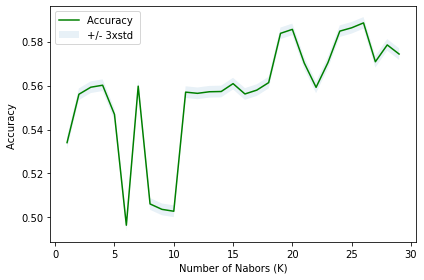

In [37]:
plt.plot(range(1,Ks),mean_acc,'g')
plt.fill_between(range(1,Ks),mean_acc - 1 * std_acc,mean_acc + 1 * std_acc, alpha=0.10)
plt.legend(('Accuracy ', '+/- 3xstd'))
plt.ylabel('Accuracy ')
plt.xlabel('Number of Nabors (K)')
plt.tight_layout()
plt.show()

### Logistic Regression

In [21]:
# Building the LR Model
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
LR = LogisticRegression(C=6, solver='liblinear').fit(X_train,y_train)
LR

LogisticRegression(C=6, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

In [22]:

# Train Model & Predicr
LRyhat = LR.predict(X_test)
LRyhat

array([1, 1, 1, ..., 1, 1, 2])

In [23]:
yhat_prob = LR.predict_proba(X_test)
yhat_prob

array([[0.63206507, 0.36793493],
       [0.54537934, 0.45462066],
       [0.7190647 , 0.2809353 ],
       ...,
       [0.54669814, 0.45330186],
       [0.54537934, 0.45462066],
       [0.35097023, 0.64902977]])

### Decision Tree

In [24]:
# Building the Decision Tree
from sklearn.tree import DecisionTreeClassifier
colDataTree = DecisionTreeClassifier(criterion="entropy", max_depth = 7)
colDataTree
colDataTree.fit(X_train,y_train)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='entropy',
                       max_depth=7, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

In [26]:
# Train Model & Predict
DTyhat = colDataTree.predict(X_test)
print (y_test [0:5])

[2 2 1 1 1]


# Results

In [42]:
from sklearn.metrics import jaccard_similarity_score
from sklearn.metrics import f1_score
from sklearn.metrics import log_loss

### K-Nearest Neighbours

In [40]:
# Jaccard Similarity Score
jaccard_similarity_score(y_test, Kyhat)

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:664: FutureWarning: jaccard_similarity_score has been deprecated and replaced with jaccard_score. It will be removed in version 0.23. This implementation has surprising behavior for binary and multiclass classification tasks.
  FutureWarning)


0.5885200355168562

In [41]:
# F1-SCORE
f1_score(y_test, Kyhat, average='macro')

0.584730839962569

### Logistic Regression

In [30]:
# Jaccard Similarity Score
jaccard_similarity_score(y_test, LRyhat)

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:664: FutureWarning: jaccard_similarity_score has been deprecated and replaced with jaccard_score. It will be removed in version 0.23. This implementation has surprising behavior for binary and multiclass classification tasks.
  FutureWarning)


0.599031879242689

In [31]:
# F1-SCORE
f1_score(y_test, LRyhat, average='macro')

0.5949659784518213

In [32]:
# LOGLOSS
yhat_prob = LR.predict_proba(X_test)
log_loss(y_test, yhat_prob)

0.6630838805740291

### Decision Tree

In [53]:
# Jaccard Similarity Score
jaccard_similarity_score(y_test, DTyhat)

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:664: FutureWarning: jaccard_similarity_score has been deprecated and replaced with jaccard_score. It will be removed in version 0.23. This implementation has surprising behavior for binary and multiclass classification tasks.
  FutureWarning)


0.6054478274568212

In [54]:
# F1-SCORE
f1_score(y_test, DTyhat, average='macro')

0.5980259628498739

# Discussion
From the results we can see that the Logistic Regression model performed better than the K-Nearest Neighbours and Decision Tree models. From the results obtained it is clear that the selected training attributes have some correlation with the target variable (Severity) but this correlation is not strong enough as the models in overall were not of very high accuracy. This maybe improved by selecting better training attributes that maybe be stronger predictors of the target variable.

#Conclusion
The trained models were of decent accuracy, but for future work this level of accuracy can be improved as it's not near the desired level of accuracy.

# References
[1] World Health Organization (WHO). Global Status Report on Road Safety 2018. December 2018. [cited 2019 April 8].Available from URL:https://www.who.int/violence_injury_prevention/road_safety_status/2018/en/external_icon